# `ruckus` is a package for building networks of reproducing kernel Hilbert spaces for data analysis.

Reproducing kernel Hilbert spaces (RKHS's, or, as I say it, "ruckuses") form the mathematical bedrock of numerous machine learning techniques, from support vector machines and Gaussian processes to neural tangent kernels and random feature embeddings. 

The classes and methods defined in this package are meant to be compatible with other popular machine learning APIs, in particular `scikit-learn`. The core object of the package is the `RKHS` class. An `RKHS` can be `fit` to data, can `transform` data by embedding it in the Hilbert space coordinates and can `fit_function`s using kernel ridge regression. Averaging kernel embeddings over a sample of data points yields the kernel mean embedding of the data's distribution, and the `KernelHerd` object can be applied to these embeddings to sample data using the kernel herding algorithm. 

Specific `RKHS` implementations included are:

1. `EigenRKHS` which uses a singular value decomposition of a specified kernel matrix to construct the embedding;
2. `RandomFourierRBF` which uses Gaussian-sampled Fourier phase terms to construct embedding vectors;
3. `OneHotRKHS` which embeds categorical data in probability space.

Further, `RKHS` instances can be composed into networks by use of the classes:

1. `CompositeRKHS` which allows for the function composition of embeddings to produce pipelines and deep kernels;
2. `ProductRKHS` which allows for Hilbert spaces with tensor product structure, and includes methods for performing conditional density embeddings across factor spaces;
3. `DirectSumRKHS` which allows for stacking RKHS embeddings along a concatenated axis,
4. `ConvolutionalRKHS` which allows for using any RKHS as a convolutional filter on `n`-D data.

On top of this, several helper functions and classes are included to provide compatibility with cross-validation and model selection via `scikit-learn`.

# Installation

To install from `pip`, run

```
>>> pip install ruckus
```

To build from source, you can either download the 
[zip](https://github.com/samlikesphysics/ruckus/archive/main.zip) 
or [tarball](https://github.com/samlikesphysics/ruckus/tarball/main) directly, 
or clone the GitHub repository via

```
>>> git clone https://github.com/samlikesphysics/ruckus.git
```

Then run in the the same folder as `setup.py`:

```
>>> python setup.py build
>>> python -m pip install .
```

# Dependencies

`ruckus` depends on the following packages:

|  Package  | Recommended version |
| --------- | ------------------- |
| `numpy`   | 1.20.1              |
| `scipy`   | 1.7.0               |
| `sklearn` | 1.0.1               |

# Example

Let us generate a dataset of the evolution of the Lorenz attractor:

In [4]:
import ruckus
import numpy as np
import matplotlib.pyplot as plt

def lorenz(n=100,s=10, r=28, b=2.667, dt=0.01):
    xs = np.empty(n + 1)
    ys = np.empty(n + 1)
    zs = np.empty(n + 1)
    xs[0], ys[0], zs[0] = (0., 1., 1.05)
    for i in range(1,n+1):
        xs[i] = xs[i-1] + (s*(ys[i-1] - xs[i-1]))*dt
        ys[i] = ys[i-1] + (r*xs[i-1] - ys[i-1] - xs[i-1]*zs[i-1])*dt
        zs[i] = zs[i-1] + (xs[i-1]*ys[i-1] - b*zs[i-1])*dt
    return np.concatenate([xs[None,:],ys[None,:],zs[None,:]]).T

X = lorenz(10000)

We wish to learn how any window of $10$ timesteps may be predicted from the preceding $2$ timesteps. To do this, we would set up a convolutional filter which takes blocks of length $12$, and uses an RKHS to embed the length-2 past blocks and length-10 future blocks separately. We could use these embeddings in a product space to learn their joint distribution and compute the conditional distribution of the future window, conditioned on the past window. This can be done using the simple code:

In [5]:
Lp = 2
Lf = 10
beta=0.5

conv_net = ruckus.convolution.ConvolutionalRKHS(
    # Convolution window includes past and future
    window_shape=(Lp+Lf,),
    # Setup filter RKHS
    rkhs=ruckus.ProductRKHS([
        # Use Random Fourier Features
        ruckus.RandomFourierRBF(
            gamma=0.1,n_components=1024,
            # Take all 3 variables and past Lp timesteps
            take=(np.array([[0],[1],[2]]),
                    np.array([list(range(Lp))])),
            # Exponentially punish further-past points
            filter=np.array([[beta**k for k in range(Lp)][::-1]]*3),
            copy_X=False
        ),
        # Use Random Fourier Features
        ruckus.RandomFourierRBF(
            gamma=0.1,n_components=1024,
            # Take all 3 variables and future Lf timesteps
            take=(np.array([[0],[1],[2]]),
                    np.array([list(range(Lp,Lp+Lf))])),
            # Exponentially punish further-future points
            filter=np.array([[beta**k for k in range(Lf)]]*3),
            copy_X=False
        ),
    ],copy_X=False)
)

# Fit convolutional kernel network on data
conv_net.fit(X)

# Extract conditional distribution
conditional_map, future_space = conv_net.rkhs.conditional([0],[1],alpha=1e-6)

Let's judge our work: for any time index `j` we can take the preceding two timesteps, use `conditional_map` to predict the embedding of the future ten timesteps, and generate forecasts using `KernelHerd`.

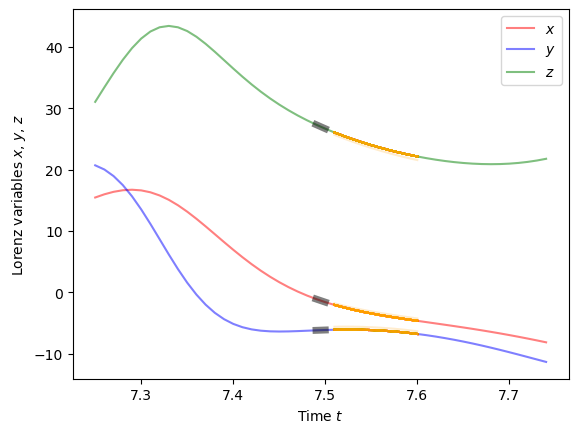

In [6]:
j = 750
dt = 0.01
rng = [j-25,j+25]
n_samples = 100
colors = ['r','b','g']
names = [r'$x$',r'$y$',r'$z$']

for k in range(3):
    plt.plot(np.arange(rng[0],rng[1])*dt,X[rng[0]:rng[1],k],alpha=0.5,c=colors[k],label=names[k])
    plt.plot(np.arange(j-Lp+1,j+1)*dt,X[j-Lp+1:j+1,k],c='k',linewidth=5,alpha=0.5)

samples = np.array(list(ruckus.sampling.KernelHerd(
    conditional_map.predict(X[j-Lp+1:j+Lf+1,].T[None])[0],
    future_space,
    size=n_samples
)))

for s in samples:
    for k in range(3):
        plt.plot(np.arange(j+1,j+Lf+1)*dt,list(s[k][Lp:]),alpha=0.1,c='orange')

plt.ylabel(r'Lorenz variables $x$, $y$, $z$')
plt.xlabel(r'Time $t$')
plt.legend()
plt.savefig('Lorenz.png')
plt.show()

Naturally, this is not quite the best way to "learn" the Lorenz attractor; better methods would use our conditional embeddings to extract information about the dynamical system and then use *that* knowledge to make forecasts. This can also be done using the tools in `ruckus` - but is left as an exercise to the reader!